# Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchmetrics import Accuracy
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import classification_report

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from datetime import datetime

In [3]:
from IPython.display import clear_output
import os, sys, shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm, trange
from glob import glob
import random
import cv2 as cv
import torch.nn.functional as F

In [4]:
data_dir = "/media/mountHDD2/khoibaocon"
print(os.listdir(data_dir))

['TrainingSet3', 'Label.csv', 'alldata', 'TrainingSet1', 'single_label.csv', 'TrainingSet2']


In [5]:
main_df = pd.read_csv(data_dir + "/Label.csv")
main_df.shape

(6877, 4)

In [6]:
single_main_df = main_df[main_df["Second_label"].isnull()]
single_fns = single_main_df["Recording"].values.tolist()
single_mat_paths = [data_dir + f"/alldata/{x}.mat" for x in single_fns]

In [7]:
ratio = [0.8, 0.1, 0.1]

train_index = int(len(single_mat_paths)*ratio[0])
valid_index = int(len(single_mat_paths)*(ratio[0]+ratio[1]))

train_mat_paths = single_mat_paths[:train_index]
valid_mat_paths = single_mat_paths[train_index:valid_index]
test_mat_paths = single_mat_paths[valid_index:]

train_label = single_main_df.iloc[:train_index,:]
valid_label = single_main_df.iloc[train_index:valid_index,:]
test_label = single_main_df.iloc[valid_index:,:]

In [8]:
print(os.getcwd())

/home/linhpika/git/HeartResearch/Experiment/Approach/EfficientB0/Focal_Loss


In [9]:
save_dir = "/home/linhpika/git/HeartResearch/Experiment/Approach/EfficientB0/Focal_Loss"

 # Data Loader

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.functional import one_hot

In [11]:
class HeartData(Dataset):
    def __init__(self, data_paths, label_df):
        self.data_paths = data_paths
        random.shuffle(self.data_paths)
        self.label_df = label_df
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.Resize((224, 224), antialias=None),
            normalize
        ])

    def __getitem__(self, idx):
        data_path = self.data_paths[idx]        
        data = loadmat(data_path)['ECG'][0][0][2]
        clip_data = data[:, 500:3000]
        clip_data = torch.tensor(clip_data, dtype=torch.float32)
        normalized_data = (clip_data - clip_data.min()) / (clip_data.max() - clip_data.min())
        grayscale_images = (normalized_data * 255)
        grayscale_images = grayscale_images.unsqueeze(0).unsqueeze(0) # (1, 1, h, w)
        resized_images = F.interpolate(grayscale_images, size=(12*4,2500), mode='bilinear', align_corners=True)
        resized_images = resized_images.squeeze(0).squeeze(0)
        torch_data = resized_images.unsqueeze(0).repeat(3, 1, 1)
        torch_data_resize = self.transform(torch_data)

        filename = data_path.split("/")[-1].split(".")[0]
        label = self.label_df[self.label_df["Recording"] == filename]["First_label"].values.item()

        return torch_data_resize, label-1

    def __len__(self):
        return len(self.data_paths)    


In [12]:
train_ds = HeartData(train_mat_paths, single_main_df)
valid_ds = HeartData(valid_mat_paths, single_main_df)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
batch_size = 64

traindl = DataLoader(
    train_ds,
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

validdl = DataLoader(
    valid_ds,
    batch_size=1, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

In [14]:
for batch, (valid_sig, valid_label) in tqdm(enumerate(validdl)):
    print(valid_label.shape)

108it [00:00, 163.58it/s]

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

323it [00:01, 466.41it/s]

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

526it [00:01, 690.02it/s]

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

640it [00:01, 447.71it/s]

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


# Model 

In [15]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn

class HeartModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ori_model = efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.ori_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 9),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x):        
        x = self.ori_model(x)
        return x

model = HeartModel()
# x = torch.randn((1, 3, 256, 512)).to("cuda")
# out = model(x)
# print(out.shape)

In [16]:
model

HeartModel(
  (ori_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

# Training

In [17]:
epoch = 1
lr = 0.001 # lr = 0.001 Acc: 0.821875 lr = 0.0005 Acc: 0.825 Focal_loss Acc: 0.828
best_acc = 0
best_ep = 0

model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epoch*len(traindl))
loss_fn = nn.CrossEntropyLoss()

In [18]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2, weight=None):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.weight = weight
# #         self.reduction = reduction

#     def forward(self, inputs, target):
#         """
#         input: [N, C], float32
#         target: [N, ], int64
#         """
#         logpt = F.log_softmax(inputs, dim=1)
#         pt = torch.exp(logpt)
#         logpt = (1-pt)**self.gamma * logpt
#         loss = F.nll_loss(logpt, target, self.weight)
#         return loss
    
# focalloss_fn = FocalLoss()

# 0.1 - 0.001 - 82.1
# 0.1 - 0.0005 - 81.7

In [19]:
class FocalClassifierV0(nn.Module):
    def __init__(self, gamma=0.3):
        super().__init__()
        
        self.gamma = gamma
        self.act = nn.LogSoftmax(dim=1)

    
    def forward(self, pred, target):

        logits = self.act(pred)

        B, C = tuple(logits.size())

        entropy = torch.pow(1 - logits, self.gamma) * logits * F.one_hot(target, num_classes=C).float()

        return (-1 / B) * torch.sum(entropy)

focalloss_fn = FocalClassifierV0()

In [30]:
def loss_plot(train_losses, val_losses, n_epochs, check_folder):
    now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
    run_dir = save_dir + f"/{check_folder}"
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
    save_loss_dir = run_dir + "/save_losses"
    if not os.path.exists(save_loss_dir):
        os.mkdir(save_loss_dir)
    save_fig_losses = os.path.join(save_loss_dir, f"plot_losses_epoch{n_epochs}_{now}.png")  

    plt.figure()
    plt.plot(range(epoch), np.array(train_losses), label='Train Loss')
    plt.plot(range(epoch), np.array(val_losses), label='Test Loss')
    plt.xlabel('Epoch')
    # plt.xticks()
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.savefig(save_fig_losses)
    

def acc_plot(train_cls_acc, val_cls_acc, n_epochs, check_folder):
    now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
    run_dir = os.getcwd() + f"/{check_folder}"
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
#         save_dir = run_dir + f"/{now}"
#         if not os.path.exists(save_dir):
#             os.mkdir(save_dir)
    save_acc_dir = run_dir + "/save_acc"
    if not os.path.exists(save_acc_dir):
        os.mkdir(save_acc_dir)
    save_fig_acc = os.path.join(save_acc_dir, 'plot_acc_epoch{}_{}.png'.format(n_epochs, now))  

    plt.figure()
    plt.plot(range(epoch), np.array(train_cls_acc), label='Train Accuracy')
    plt.plot(range(epoch), np.array(val_cls_acc), label='Test Accuracy')
    plt.xlabel('Epoch')
    # plt.xticks
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.savefig(save_fig_acc)

    
def checkpoint(valid_class_acc, 
               val_total_loss,
               old_valid_class_acc,
               old_valid_loss,
               epoch, 
               model,
               optimizer,
               check_folder
#                    logs
              ):

    if valid_class_acc >= old_valid_class_acc and val_total_loss <= old_valid_loss:
        old_valid_class_acc = valid_class_acc
        old_valid_loss = val_total_loss
        save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_total_loss,
            'test_acc': valid_class_acc
        }

     # Saving best model
        now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
        run_dir = os.getcwd() + f"/{check_folder}"
        if not os.path.exists(run_dir):
            os.mkdir(run_dir)
    #         save_dir = run_dir + f"/{now}"
    #         if not os.path.exists(save_dir):
    #             os.mkdir(save_dir)
        save_best_model_dir = run_dir + "/save_best_model"
        if not os.path.exists(save_best_model_dir):
            os.mkdir(save_best_model_dir)
        save_best_model_path = save_best_model_dir + f"/{save_dict['loss']:>7f}_{save_dict['test_acc']:>7f}_{now}.pt"
        torch.save(save_dict, save_best_model_path)
        
def classification_report_csv(report, check_folder):
    now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
    run_dir = save_dir + f"/{check_folder}"
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
    save_report_dir = run_dir + "/save_classification_report"
    if not os.path.exists(save_report_dir):
        os.mkdir(save_report_dir)
        
    report_data = []
    lines = report.split('\n')
    print(lines)
    print(type(lines))
    print(lines[2:-3])
    for line in lines[2:-3]:
        row = {'class', }
        row_data = line.split('        ')
        print(row_data)
        print(len(row_data))
        print(f"Hihi"{row_data[0]})
#         row['class'] = row_data[0]
#         row['precision'] = float(row_data[1])
#         row['recall'] = float(row_data[2])
#         row['f1_score'] = float(row_data[3])
#         row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    save_report_file = save_report_dir + f"/classification_report_{now}.csv"
    dataframe.to_csv(save_report_file, index = False)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2033159350.py, line 101)

In [21]:
a = [1, 2,3 ,4 ,5]
print(a[1:-2])


[2, 3]


In [22]:
from collections import OrderedDict

import torch
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

manual_seed(666)


metric = ClassificationReport(output_dict=True)
metric.attach(default_evaluator, "cr")
y_true = torch.tensor([2, 0, 2, 1, 0, 1])
y_pred = torch.tensor([
    [0.0266, 0.1719, 0.3055],
    [0.6886, 0.3978, 0.8176],
    [0.9230, 0.0197, 0.8395],
    [0.1785, 0.2670, 0.6084],
    [0.8448, 0.7177, 0.7288],
    [0.7748, 0.9542, 0.8573],
])
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["cr"].keys())
print(state.metrics["cr"]["0"])
print(state.metrics["cr"]["1"])
print(state.metrics["cr"]["2"])
print(state.metrics["cr"]["macro avg"])
print(type(state.metrics["cr"]["macro avg"]))

dict_keys(['0', '1', '2', 'macro avg'])
{'precision': 0.5, 'recall': 0.5, 'f1-score': 0.49999999999999944}
{'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666662}
{'precision': 0.3333333333333333, 'recall': 0.5, 'f1-score': 0.3999999999999995}
{'precision': 0.611111111111111, 'recall': 0.5, 'f1-score': 0.5222222222222217}
<class 'dict'>


In [23]:
x = torch.tensor([1])
y = torch.tensor([2])
t = torch.tensor([6])
# z = torch.cat((x, y, t), 0)
# k = torch.cat(z,0, out = x)
# print(k)
lists = [x,y]
z = torch.cat(lists)
print(z)

tensor([1, 2])


Epoch: 1


80it [00:07, 10.55it/s]

train loss: 2.305154842666433 - train acc: 69.39453125



640it [00:05, 124.62it/s]


valid loss: 1.6988552327447095 - valid acc: 67.1875
Best acuracy: 0.7 at epoch 0
              precision    recall  f1-score   support

           1       0.66      0.47      0.54        86
           2       0.76      0.88      0.82       109
           3       0.70      0.84      0.76        76
           4       0.88      0.73      0.80        30
           5       0.79      0.84      0.81       134
           6       0.28      0.33      0.30        52
           7       0.62      0.58      0.60        60
           8       0.56      0.59      0.58        75
           9       0.00      0.00      0.00        18

    accuracy                           0.67       640
   macro avg       0.58      0.58      0.58       640
weighted avg       0.65      0.67      0.66       640

['              precision    recall  f1-score   support', '', '           1       0.66      0.47      0.54        86', '           2       0.76      0.88      0.82       109', '           3       0.70      0.84    

/home/linhpika/git/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/linhpika/git/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/linhpika/git/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


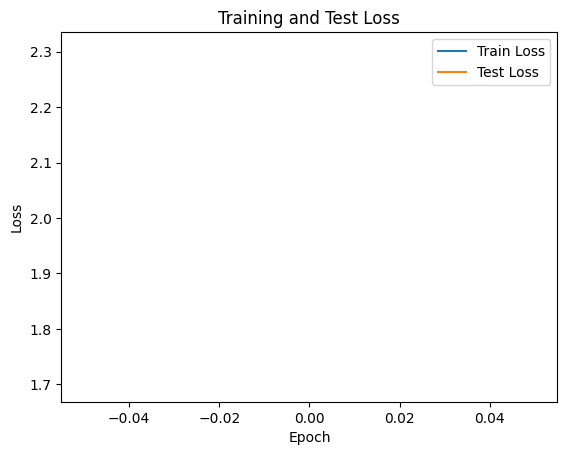

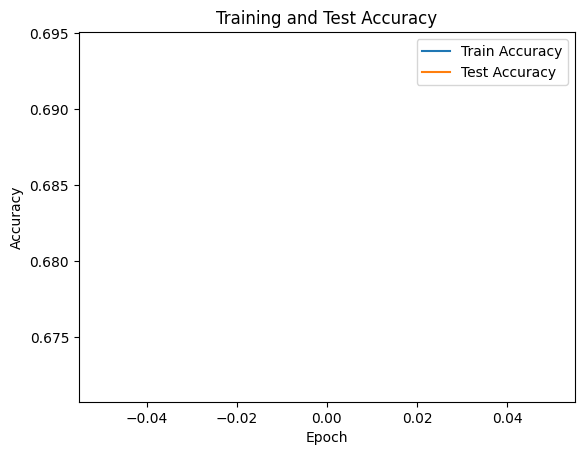

In [31]:
# Training
checkpoint_folder = "run_efficientB0_heatmap_gamma0.1"
class_la = [1,2,3,4,5,6,7,8,9]
train_losses = []
train_acc_plot = []
val_losses = []
val_acc_plot = []
old_valid_class_acc = 0
old_valid_loss = 1e23
for e in range(epoch):
    model.train()
    print(f"Epoch: {e+1}")
    batch_cnt = 0
    total_loss = 0
    correct = 0
    for batch, (train_sig, train_label) in tqdm(enumerate(traindl)):
        batch_cnt = batch
        train_sig = train_sig.to(device)
        train_label = train_label.to(device)
        
        pred = model(train_sig)
        loss = focalloss_fn(pred, train_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        
        total_loss += loss.item()
        correct += (pred.argmax(1) == train_label).type(torch.float).sum().item()
        
    total_loss /= batch_cnt
    correct /= len(traindl.dataset)
    train_losses.append(total_loss)
    train_acc_plot.append(correct)
    
    print(f"train loss: {total_loss} - train acc: {100*correct}")

# Valid
    batch_cnt = 0
    val_total_loss = 0
    val_correct = 0
    model.eval()
    y_true_list = [] 
    pred_list = []
    with torch.no_grad():
        for batch, (valid_sig, valid_label) in tqdm(enumerate(validdl)):
            batch_cnt = batch
            valid_label = valid_label.to(device)
            
            valid_sig = valid_sig.to(device)  
            pred = model(valid_sig)
            pred_pos = pred.argmax(1)
            
            y_true_list.append(valid_label)
            pred_list.append(pred_pos)
            
            loss = loss_fn(pred, valid_label)
            val_total_loss += loss.item()
            val_correct += (pred.argmax(1) == valid_label).type(torch.float).sum().item()
            

            
        val_total_loss /= batch_cnt
        val_correct /= len(validdl.dataset)
        val_losses.append(val_total_loss)
        val_acc_plot.append(val_correct)

        if val_correct > best_acc:
            best_acc = val_correct
            best_ep = e 

        print(f"valid loss: {val_total_loss} - valid acc: {100*val_correct}")
        checkpoint(valid_class_acc = val_correct, 
                   val_total_loss = val_total_loss,
                   old_valid_class_acc = old_valid_class_acc ,
                   old_valid_loss = old_valid_loss,
                   epoch = e, 
                   model = model,
                   optimizer = optimizer,
                   check_folder = checkpoint_folder)
        
print(f"Best acuracy: {best_acc} at epoch {best_ep}")

loss_plot(train_losses = train_losses, 
          val_losses = val_losses, n_epochs = e , 
          check_folder = checkpoint_folder)
acc_plot(train_cls_acc = train_acc_plot , val_cls_acc = val_acc_plot, 
                  n_epochs = e, check_folder = checkpoint_folder)

y_true = torch.cat(y_true_list).cpu().numpy()
pred = torch.cat(pred_list).cpu().numpy()

for i in range (len(class_la)):
    class_la[i] = str(class_la[i])

# Classification report
reports = classification_report(y_true, pred, target_names=class_la) 
print(reports)
classification_report_csv(report = reports, check_folder = checkpoint_folder)


# Classification report
# metric = ClassificationReport(output_dict=True)
# metric.attach(default_evaluator, "cr")
# state = default_evaluator.run([[pred_tensor, y_true_tensor]])
# print(state.metrics["cr"].keys())
# print(state.metrics["cr"]["macro avg"])




# ROC Curve
#         for i in range(9):
#             r2 = roc_auc_score(valid_label[:, i].cpu(), pred[:, i].cpu())
#             print("The ROC AUC score of "+ class_la[i] +" is: "+str(r2))

#                     # Compute ROC curve and ROC area for each class
#         class_fpr = {}
#         class_tpr = {}
#         class_roc_auc = dict()
#         for i in range(9):
#             class_fpr[i], class_tpr[i], _ = roc_curve(valid_label[:, i].cpu(), pred[:, i].cpu(), drop_intermediate=False)
#             roc_auc[i] = auc(class_fpr[i], class_tpr[i])
            
#         now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
#         run_dir = save_dir + f"/{check_folder}"
#         if not os.path.exists(run_dir):
#             os.mkdir(run_dir)
#         save_ROC_dir = run_dir + f"/save_ROC_{now}"
#         if not os.path.exists(save_ROC_dir):
#             os.mkdir(save_ROC_dir)
        
#         plt.plot(class_fpr[0], class_tpr[0],'turquoise',label='1: ROC curve of class 1 (area = %0.2f)' % roc_auc[0])
#         plt.plot(class_fpr[1], class_tpr[1],'peachpuff',label='2: ROC curve of class 2 (area = %0.2f)' % roc_auc[1])
#         plt.plot(class_fpr[2], class_tpr[2],'paleturquoise',label='3: ROC curve of class 3 (area = %0.2f)' % roc_auc[2])
#         plt.plot(class_fpr[3], class_tpr[3],'pink',label='4: ROC curve of class 4 (area = %0.2f)' % roc_auc[3])
#         plt.plot(class_fpr[4], class_tpr[4],'lightcoral',label='5: ROC curve of class 5 (area = %0.2f)' % roc_auc[4])
#         plt.plot(class_fpr[5], class_tpr[5],'peachpuff',label='6: ROC curve of class 6 (area = %0.2f)' % roc_auc[5])
#         plt.plot(class_fpr[6], class_tpr[6],'steelblue',label='7: ROC curve of class 7 (area = %0.2f)' % roc_auc[6])
#         plt.plot(class_fpr[7], class_tpr[7],'forestgreen',label='8: ROC curve of class 8 (area = %0.2f)' % roc_auc[6])
#         plt.plot(class_fpr[8], class_tpr[8],'darkslategray',label='9: ROC curve of class 9 (area = %0.2f)' % roc_auc[6])

#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlim([-0.1, 1.1])
#         plt.ylim([-0.1, 1.1])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver operating characteristic of lead')
#         plt.legend(loc="lower right")
#         plt.savefig(save_ROC_dir)



# Evaluation